In [10]:
import cv2
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import rotate


In [41]:
def remove_background_static(frame, background):
    """
    Remove the background from a frame using a static background image.
    """
    mask = np.abs(frame - background) > 30
    frame[mask] = 0
    return frame

def remove_background_dynamic(frames):
    """
    Remove the background from a sequence of frames using a learned background model.
    """
    bg_model = cv2.createBackgroundSubtractorMOG2()
    processed_frames = []

    for frame in frames:
        mask = bg_model.apply(frame)
        processed_frame = cv2.bitwise_and(frame, frame, mask=mask)
        processed_frames.append(processed_frame)

    return processed_frames

def segment_ball(frame):
    """
    Segment the ping-pong ball from a frame using size and circularity filters.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary = binary_fill_holes(binary)

    labels = measure.label(binary, connectivity=2)
    properties = measure.regionprops(labels)

    # Filter out small and large objects
    filtered_properties = [prop for prop in properties
                           if 500 < prop.area < 3000]

    # Find the most circular object
    if filtered_properties:
        filtered_properties.sort(key=lambda prop: prop.solidity, reverse=True)
        ball_mask = labels == filtered_properties[0].label
        ball_mask = np.dstack([ball_mask] * 3).astype(np.uint8) * 255
    else:
        ball_mask = np.zeros_like(frame)

    return ball_mask

def process_video(input_video, output_video, background=None):
    """
    Process a video by removing the background and segmenting the ping-pong ball.
    """
    print("running process_video")
    cap = cv2.VideoCapture(input_video)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    if background is not None:
        background = cv2.imread(background)

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    if background is not None:
        processed_frames = [remove_background_static(frame, background) for frame in frames]
    else:
        processed_frames = remove_background_dynamic(frames)

    for frame in processed_frames:
        ball_mask = segment_ball(frame)
        out.write(ball_mask)

    cap.release()
    out.release()

def showfirstFrame():
    """Show the first frame of the video with the background removed and segmented ball."""
    cap = cv2.VideoCapture('15.mp4')
    ret, frame = cap.read()
    background = cv2.imread('background.jpg')
    processed_frame = remove_background_static(frame, background)
    ball_mask = segment_ball(processed_frame)
    plt.imshow(rotate(cv2.cvtColor(ball_mask, cv2.COLOR_BGR2RGB), 90))
    plt.show()

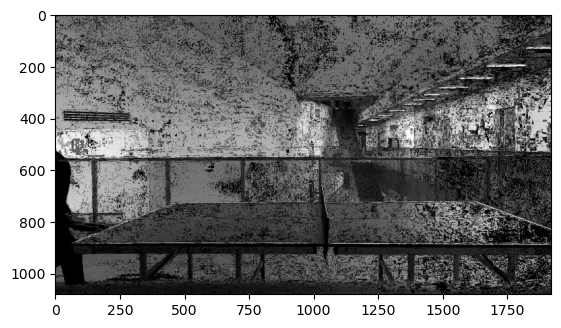

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [42]:
# lets teast each function on an example frame and display it using mpl
def test_remove_background_static():
    frame = cv2.imread('org_frame_250.jpg')
    background = cv2.imread('background.jpg')
    processed_frame = remove_background_static(frame, background)
    # plot it in grayscale
    plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2GRAY), cmap='gray')
    plt.show()

def test_remove_background_dynamic():
    frame = cv2.imread('org_frame_250.jpg')
    processed_frame = remove_background_dynamic(frame)
    plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
    plt.show()

test_remove_background_static()
test_remove_background_dynamic()


In [20]:
if __name__ == "__main__":
    process_video("15v2.mp4", "output_static2.mp4", "background.jpg")
    process_video("15v2.mp4", "output_dynamic2.mp4")

running process_video
running process_video


In [2]:
# # take the first frame of back_cut.mp4 and save it as background.jpg
# cap = cv2.VideoCapture("back_cut.mp4")
# ret, frame = cap.read()
# cv2.imwrite("background.jpg", frame)
# cap.release()